In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [2]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define your scaling function
def custom_scaling_1(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    # input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# 4 input 7 output

## Search N and H

In [3]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")
df = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 1.9246611595153809, Val Loss: 1.2758673429489136
Epoch 2/100, Loss: 1.2792797088623047, Val Loss: 0.7990705370903015
Epoch 3/100, Loss: 1.1202971935272217, Val Loss: 0.7458369135856628
Epoch 4/100, Loss: 1.0749698877334595, Val Loss: 0.6917657852172852
Epoch 5/100, Loss: 1.0608856678009033, Val Loss: 0.7125511765480042
Epoch 6/100, Loss: 1.0439070463180542, Val Loss: 0.6502262353897095
Epoch 7/100, Loss: 1.0403363704681396, Val Loss: 0.6998559832572937
Epoch 8/100, Loss: 1.0276991128921509, Val Loss: 0.7439783811569214
Epoch 9/100, Loss: 1.0303202867507935, Val Loss: 0.6792675256729126
Epoch 10/100, Loss: 1.0157759189605713, Val Loss: 0.6413421630859375
Epoch 11/100, Loss: 1.0123485326766968, Val Loss: 0.6187499761581421
Epoch 12/100, Loss: 1.0172274112701416, Val Loss: 0.6546234488487244
Epoch 13/100, Loss: 1.0214985609054565, Val Loss: 0.7224487066268921
Epoch 14/100, Loss: 1.0106250047683716, Val Loss: 0.6207059621810913
Epoch 15/100, Loss: 1.006225824356079, Val 

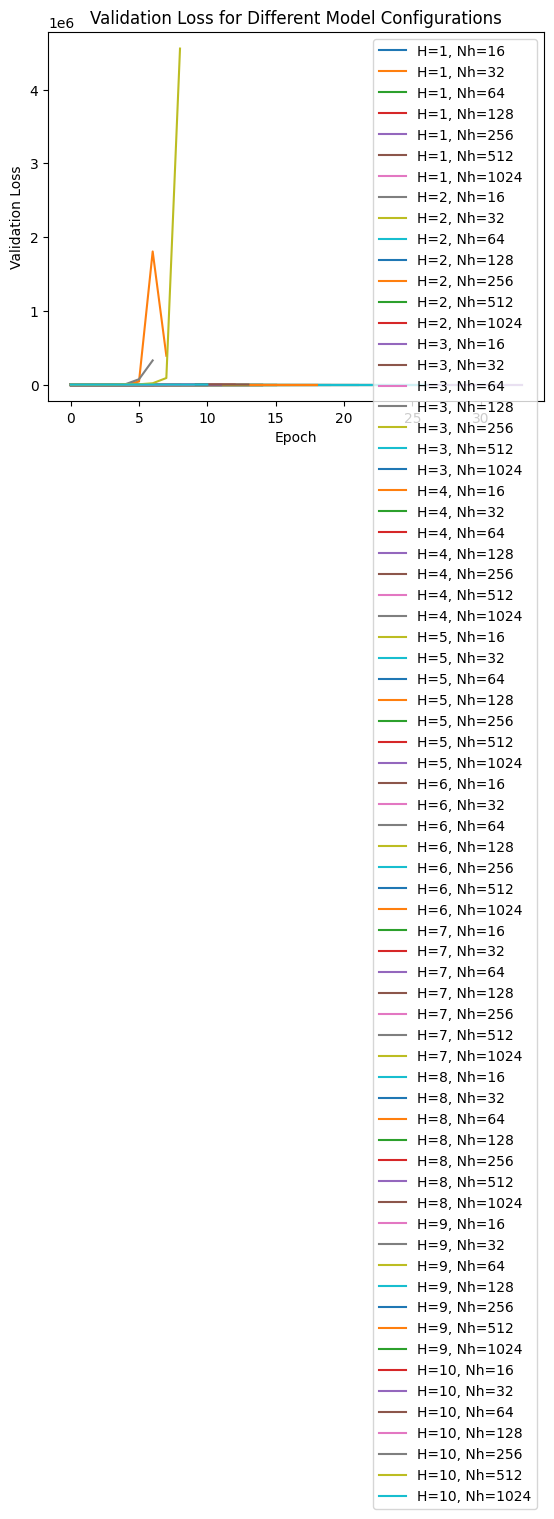

Model with H=1 and Nh=16:
MSE: 0.6265968084335327
MAE: 0.6265967038621006
RMSE: 4.066911395367891
R-squared: 0.8955285863241139
MAPE: 17.907965061773222%
Model with H=1 and Nh=32:
MSE: 0.6190970540046692
MAE: 0.6190972540102516
RMSE: 2.9397455427177785
R-squared: 0.9274537450970973
MAPE: 16.19143216080721%
Model with H=1 and Nh=64:
MSE: 0.5211517214775085
MAE: 0.5211517868389837
RMSE: 2.3811141792798383
R-squared: 0.9483135356150829
MAPE: 14.110040269276675%
Model with H=1 and Nh=128:
MSE: 0.4933047294616699
MAE: 0.49330505343714265
RMSE: 2.095916714663894
R-squared: 0.947496293681229
MAPE: 14.718506945916932%
Model with H=1 and Nh=256:
MSE: 0.435322642326355
MAE: 0.4353226992604551
RMSE: 1.9247939746480383
R-squared: 0.9763656947150536
MAPE: 12.218814356338726%
Model with H=1 and Nh=512:
MSE: 0.4233657121658325
MAE: 0.4233654101177021
RMSE: 2.003236027742635
R-squared: 0.9580745978570425
MAPE: 11.930948599224246%
Model with H=1 and Nh=1024:
MSE: 0.38290804624557495
MAE: 0.382908039038

In [4]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


### Ranking

In [5]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=6, Nh=256 - MSE: 0.19650597870349884
Rank 2: Combination H=4, Nh=128 - MSE: 0.21628442406654358
Rank 3: Combination H=4, Nh=256 - MSE: 0.2414274513721466
Rank 4: Combination H=6, Nh=128 - MSE: 0.2559279501438141
Rank 5: Combination H=7, Nh=64 - MSE: 0.27813419699668884
Rank 6: Combination H=5, Nh=256 - MSE: 0.29665935039520264
Rank 7: Combination H=4, Nh=64 - MSE: 0.3053044378757477
Rank 8: Combination H=9, Nh=64 - MSE: 0.30768752098083496
Rank 9: Combination H=3, Nh=256 - MSE: 0.3080404996871948
Rank 10: Combination H=5, Nh=32 - MSE: 0.3107946515083313
Rank 11: Combination H=5, Nh=64 - MSE: 0.31213831901550293
Rank 12: Combination H=8, Nh=64 - MSE: 0.31386059522628784
Rank 13: Combination H=7, Nh=128 - MSE: 0.31882333755493164
Rank 14: Combination H=5, Nh=128 - MSE: 0.3205721974372864
Rank 15: Combination H=3, Nh=128 - MSE: 0.347360759973526
Rank 16: Combination H=5, Nh=512 - MSE: 0.3490273952484131
Rank 17: Combination H=4, Nh=512 - MSE: 0.3616322875022888
Rank 

Rank 1: Combination H=5, Nh=256 - MSE: 0.2685861587524414
Rank 2: Combination H=5, Nh=512 - MSE: 0.26927897334098816
Rank 3: Combination H=4, Nh=1024 - MSE: 0.2832221984863281
Rank 4: Combination H=4, Nh=512 - MSE: 0.29064759612083435
Rank 5: Combination H=6, Nh=1024 - MSE: 0.3075002133846283
Rank 6: Combination H=7, Nh=256 - MSE: 0.32315966486930847
Rank 7: Combination H=3, Nh=256 - MSE: 0.3244527578353882
Rank 8: Combination H=4, Nh=128 - MSE: 0.32607361674308777
Rank 9: Combination H=4, Nh=256 - MSE: 0.3269226551055908
Rank 10: Combination H=5, Nh=1024 - MSE: 0.33056139945983887
Rank 11: Combination H=4, Nh=64 - MSE: 0.3360600769519806
Rank 12: Combination H=3, Nh=512 - MSE: 0.3548477292060852
Rank 13: Combination H=7, Nh=128 - MSE: 0.36053985357284546
Rank 14: Combination H=6, Nh=64 - MSE: 0.36217623949050903
Rank 15: Combination H=3, Nh=1024 - MSE: 0.3668963313102722

In [6]:
# Specify the combination you want to call
H = 6
Nh = 256

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model
selected_model.save("model_6_256_20_20_20_20.h5")
# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Evaluate the model on the testing set
mse = selected_model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

 62/750 [=>............................] - ETA: 0s

d:\Software\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 1s 819us/step - loss: 0.1965
Mean Squared Error on Testing Set: 0.19650597870349884
Predictions:
[[1.0219637e+01 4.5056027e-01 1.6853890e+00 1.6735905e+00 6.7400590e-02
  1.5987738e+00 6.8811283e-02]
 [0.0000000e+00 1.7507122e-07 1.4677124e+00 1.4832344e+00 3.5829239e-03
  3.9988381e-01 1.2376591e-01]
 [7.4750261e+00 6.6595018e-01 1.7110184e+00 1.7082503e+00 5.5595353e-02
  1.6504406e+00 6.1348688e-02]
 [8.0876646e+00 2.6589451e+00 2.5022225e+00 2.4939084e+00 1.6155841e-02
  1.0894253e+00 5.4000672e-02]
 [1.5769609e+01 7.3881488e+00 1.6915892e+00 1.6767877e+00 9.1617201e-03
  6.3844192e-01 1.0877731e-01]]
True Values:
[[1.03131378e+01 4.13992151e-01 1.68153236e+00 1.68153236e+00
  7.19429836e-02 1.63623509e+00 6.50622125e-02]
 [1.57412647e+00 5.88833103e-01 1.55288744e+00 1.55288744e+00
  7.44111990e-03 4.64687549e-01 1.37156431e-01]
 [7.26807243e+00 7.49825031e-01 1.70935463e+00 1.70935463e+00
  5.27434900e-02 1.69007496e+00 5.96008677e-02]
 

# Split Dataset

In [ ]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")
df_1 = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_1 = df_1[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_1 = df_1[["delta_current"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_1 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_1 = {}
maes_1 = {}
rmses_1 = {}
r2_scores_1 = {}
mapes_1 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

In [ ]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_1 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_1.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_1.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_1.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_1.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_1.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model_1.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_1 = model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_1

        # Evaluate the model on the testing set
        predictions_1 = model_1.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_1 = model.evaluate(X_test, y_test)
        mses_1[(H, Nh)] = mse_1

        # Calculate Mean Absolute Error (MAE)
        mae_1 = mean_absolute_error(y_test, predictions_1)
        maes_1[(H, Nh)] = mae_1

        # Calculate Root Mean Squared Error (RMSE)
        rmse_1 = np.sqrt(mean_squared_error(y_test, predictions_1))
        rmses_1[(H, Nh)] = rmse_1

        # Calculate R-squared (R2) Score
        r2_1 = r2_score(y_test, predictions_1)
        r2_scores_1[(H, Nh)] = r2_1

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_1 = np.mean(np.abs((y_test - predictions_1) / y_test)) * 100
        mapes_1[(H, Nh)] = mape_1

# Plot the validation loss for each configuration
for (H, Nh), history_1 in histories_1.items():
    plt.plot(history_1.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_1 in mses_1.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_1}')
    print(f'MAE: {maes_1[(H, Nh)]}')
    print(f'RMSE: {rmses_1[(H, Nh)]}')
    print(f'R-squared: {r2_scores_1[(H, Nh)]}')
    print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [ ]:
# Rank combinations based on their MSE values
ranked_combinations_1 = sorted(mses_1.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_1) in enumerate(ranked_combinations_1, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_1}")
